In [1]:
## Import packages

using Statistics
using Pkg
using LinearAlgebra
using StatsBase
using Random
using JLD
using Plots
using Distributions
using JSON
using MAT
Pkg.add("ColorSchemes")
using ColorSchemes
Pkg.add("PyCall")
using PyCall
nx = pyimport("networkx")
np = pyimport("numpy")

include("helper_functions.jl")

┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


  Updating registry at `/opt/julia/registries/General`
 Resolving package versions...


┌ Warning: Some registries failed to update:
│     — `/opt/julia/registries/General` — registry dirty
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Pkg/src/Types.jl:1171


  Updating `/opt/julia/environments/v1.2/Project.toml`
  [35d6a980] + ColorSchemes v3.9.0
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]


┌ Info: Recompiling stale cache file /opt/julia/compiled/v1.2/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1240


compute_probability (generic function with 1 method)

In [11]:
# Define parameters

# Read from config file
config_file = "config092420.json"
config = read_config("$(homedir())/configs/$(config_file)")

const NNODES = config["NNODES"]
const MAXDIM = config["MAXDIM"]
const NREPS = config["NREPS"]
const DATE_STRING = config["DATE_STRING"]
const SAVETAIL = config["SAVETAIL_graphInfo"]
const read_dir = "$(homedir())/$(config["read_dir_graphs"])/$(NNODES)nodes"
const save_dir = "$(homedir())/$(config["save_dir_forJason"])/$(NNODES)nodes"

# Locate graph files
graph_files = filter(x->occursin(DATE_STRING,x), readdir(read_dir))
println("Located the following graph files:")
for graph_file in graph_files
    println(graph_file)
end
model_names = [split(graph_file,"_")[1] for graph_file in graph_files]

graph_files[1]

Located the following graph files:
IID_70nodes_200reps_092420_graphs.jld
assortative_70nodes_200reps_20_5_10_5_092420_graphs.jld
coreperiphery_70nodes_200reps_15_5_10_5_092420_graphs.jld
cosineGeometric_70nodes_200reps_3_092420_graphs.jld
disassortative_70nodes_200reps_20_5_10_5_092420_graphs.jld
discreteUniformConf_70nodes_200reps_0_1000_092420_graphs.jld
dotProduct_70nodes_200reps_3_092420_graphs.jld
geometricConf_70nodes_200reps_001_100_092420_graphs.jld
randomGeom_70nodes_200reps_3_092420_graphs.jld
ringLattice_70nodes_200reps_092420_graphs.jld
rmsd_70nodes_200reps_3_092420_graphs.jld
sqdEuclidean_70nodes_200reps_3_092420_graphs.jld


"IID_70nodes_200reps_092420_graphs.jld"

In [36]:
plot_array = Any[]

for graph_file in graph_files
# graph_file = "IID_70nodes_200reps_092420_graphs.jld"
    
    graph_dict = load("$(read_dir)/$(graph_file)")
    weighted_graph_array = graph_dict["weighted_graph_array"]

    nReps = size(weighted_graph_array)[3]
    G_end = weighted_graph_array[:,:,nReps]
    G_avg = dropdims(mean(weighted_graph_array, dims=3), dims=3)

    p1a = heatmap(G_end,yflip = true, aspect_ratio=:equal, grid = false, c = :gist_yarg, axis=false, xlims=[1,70],
        framestyle=:box)
    title!("Last graph")
    ylabel!("Nodes")
    xlabel!("Nodes")
    
    # Degree distributions
    p1b = histogram([sum(G_end, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution last graph")
    ylabel!("Frequency")
    xlabel!("Node strength")


    # Edge weight distributions
    p1c = histogram(triu_elements(G_end,1), legend = false, c=:gray, alpha = 0.3)
    title!("Last graph edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")
    
    
    p1d = heatmap(G_avg,yflip = true, aspect_ratio=:equal, grid=false, c = :gist_yarg, xlims=[1,70], framestyle=:box)
    title!("Average graph")
    ylabel!("Nodes")
    xlabel!("Nodes")
    
    p1e = histogram([sum(weighted_graph_array, dims=1)...], legend = false, c=:gray, alpha = 0.3)
    title!("Strength distribution all graphs")
    ylabel!("Frequency")
    xlabel!("Node strength")

    p1f = histogram([weighted_graph_array...], legend = false, c=:gray, alpha = 0.3)
    title!("All graphs edge weight distribution")
    ylabel!("Frequency")
    xlabel!("Edge weight")


    # Graph metrics
    clustering = zeros(1,nReps)
    modularity = zeros(1,nReps)


    for rep in 1:nReps

        g = nx.from_numpy_matrix(weighted_graph_array[:,:,rep], parallel_edges=false)
        clustering[1, rep] = nx.average_clustering(g, weight = "weight")
        modularity[1, rep] = nx.algorithms.community.modularity(g, nx.algorithms.community.label_propagation_communities(g))

    end


    p1g = histogram([clustering...], legend=false, c=:gray, alpha = 0.3)
    title!("Average clustering (all graphs)")
    xlabel!("Avg. clustering")
    ylabel!("Frequency")

    p1h = histogram([modularity...], legend=false, c=:gray, alpha = 0.3)
    title!("Modularity (all graphs)")
    xlabel!("Modularity")
    ylabel!("Frequency")


#     pi1 = plot(p1a, p1b, p1c, layout = (3, 1))
        pi1 = plot(p1a, p1b, p1c, p1d, p1e, p1f, p1g, p1h, layout = (8, 1), size=(400,2000))
#         pi2 = plot(p1a,p1d, layout=(2,1))
    savefig("../figures/$(replace(graph_file, "_graphs.jld" => ""))_$(SAVETAIL).pdf")
#     push!(plot_array,pi)
end

plot(pi1)

# plot(plot_array...,  size = (1700, 5000))

Plotting thresholded graphs

In [16]:
## Make a big plot of graphs for each
const read_dir_thresh = "$(homedir())/$(config["read_dir_thresh"])/$(NNODES)nodes"

# Maybe just betti bar first

# Filter to just the thresholds

thresh_files = filter(x->occursin("thresh",x), readdir(read_dir_thresh))
thresh_files = filter(x->occursin("$(DATE_STRING)",x), thresh_files)
thresh_files = filter(x->!occursin("noiseOnly",x), thresh_files)

# Locate the thresh nametages
thresh_nametags = []
for thresh_file in thresh_files
    tag = split(split(thresh_file, "graphs_")[2], "_edge")[1]
    thresh_nametags = [thresh_nametags; tag]
end

thresh_files

0-element Array{String,1}

In [13]:
## Loop through and make big graph

for thresh_nametag in thresh_nametags
    
    thresh_files_filtered = filter(x->occursin(thresh_nametag,x), thresh_files)
    
    for thresh_file_filtered in thresh_files_filtered
        
        # read in graphs
        graph_dict = load("$(read_dir)/$(thresh_file_filtered)")
        weighted_graph_array = graph_dict["weighted_graph_array"]

        nReps = size(weighted_graph_array)[3]
        G_end = weighted_graph_array[:,:,nReps]
        
        # Convert to networkx graph
        g = nx.from_numpy_matrix(G_end, parallel_edges=false)
        nx.draw_networkx(g)
        
    end
    
end

        
        

ErrorException: File /home/jovyan/processed_data/graphs/70nodes/IID_70nodes_50reps_091520_graphs_thresh02_edge483.jld cannot be found

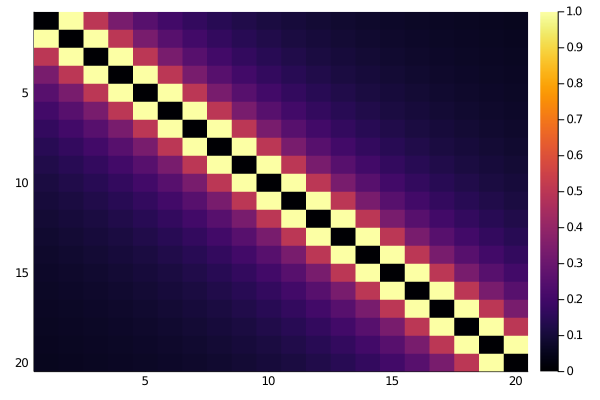

In [106]:
### Making giant star graph

adj = zeros(20,20)
nEdges = binomial(20,2)
nNodes = 20

for i=1:nNodes
    for j = (i+1):nNodes
        adj[i,j] = 1 ./abs(i-j)
        adj[j,i] = 1 ./abs(i-j)
        nEdges = nEdges-1
    end
end
    
heatmap(adj, yflip=true)
        


In [132]:
overlap_interval = [0.5, 0.6]

nNodes = 20
nEdges = binomial(nNodes, 2)
edge_weights = reverse!(collect(1:nEdges))
edge_densities = [1-(j/nEdges) for j in edge_weights]

function compute_probability(density, a, b)
    
    # Interval is [a, b]
    # p(density) = 1/(b-a) * (density - a)
    
    m = 1 ./ (b-a)
    
    return m*(density - a)
end

adj1 = make_ring_lattice_wei(20)
adj = makeEdgeWeightsUnique(adj1)
random_probabilities = compute_probability.(edge_densities,0.3, 0.7)
random_probabilities[random_probabilities .< 0] .= 0
random_probabilities[random_probabilities .> 1] .=1
# plot(edge_densities, random_probabilities)

adj_overlap = zeros(nNodes,nNodes)


a = 0.7
b = 0.8

edge_number = 1
while edge_number <= nEdges
    
    density = edge_number/nEdges
    
    p = compute_probability(density, a, b)
    
    r = rand(1)[1]
    
    if r < p
        
        # Add edge at random
        open_edges = Tuple.(findall(adj_overlap .== 0))
        open_edges = filter(x -> (x[1] != x[2]), open_edges)
        new_edge = sample(open_edges)
        
        adj_overlap[new_edge[1], new_edge[2]] = edge_number
        adj_overlap[new_edge[2], new_edge[1]] = edge_number
        
        
    else
        
        # Add edge from real graph. Take the maximum edge that could exist, because the random noise could
        # have aded the intended edge already.
        
        identified_edge_weight = maximum([adj[adj_overlap.==0]...])
#         println(identified_edge_weight)
        
        real_edges = findall(adj .== identified_edge_weight)[1]
        
       
        
        adj_overlap[real_edges[1], real_edges[2]] = edge_number
        adj_overlap[real_edges[2], real_edges[1]] = edge_number
        
        
        
    end
    
    edge_number = edge_number+1
end

heatmap(adj_overlap)
sort(unique([Int.(adj_overlap)...])) == collect(0:nEdges)

true

In [130]:
unique([Int.(adj_overlap)...])

191-element Array{Int64,1}:
   0
  19
  33
  57
  65
  86
 115
 138
 141
 180
 168
 158
 172
   ⋮
  63
  96
  14
  36
  48
  77
   2
  37
  56
  20
  31
   5

In [131]:
collect(0:nEdges)

191-element Array{Int64,1}:
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
   ⋮
 179
 180
 181
 182
 183
 184
 185
 186
 187
 188
 189
 190

In [121]:
binomial(70,2)

2415

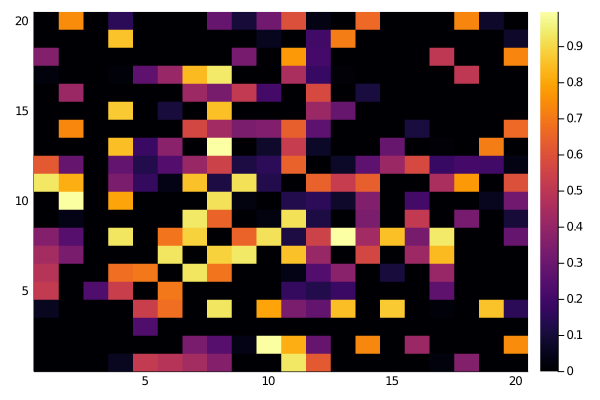

In [91]:
## Randomize edge function
include("graph_models.jl")
using Distances
adj = make_random_geometric(20,3)
adjt,t = threshold_graph(adj,0.5, 20)

function randomize_edge_weights(adj)
    
    adj_rand = copy(adj)
    adj_rand[adj_rand.>0] .=1
    noiseyG = make_iid_weighted_graph(20)
    adj_rand[adj_rand .==1] .= noiseyG[adj_rand.==1]
    
    return adj_rand
end

adjr = randomize_edge_weights(adjt)
heatmap(adjr)


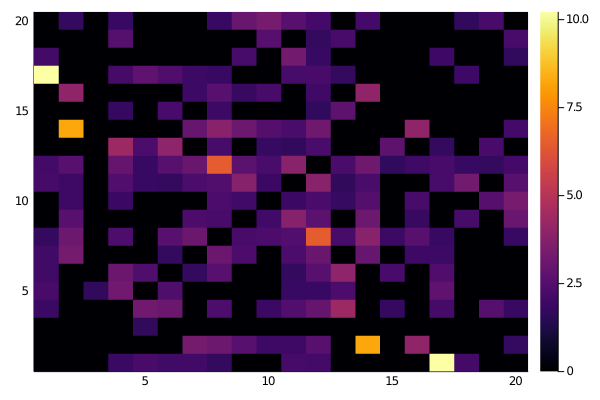

In [92]:
heatmap(adjt)

In [67]:
deleteat!(collect(1:nNodes),2)

19-element Array{Int64,1}:
  1
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20